In [1]:
# !pip install ipywidgets
# !pip install lightgbm
# !pip install torch
# !pip install catboost

In [58]:
import pandas as pd
import urllib.parse
import matplotlib.pyplot as plt
import numpy as np
import ffkkmo_ra
import ipywidgets as widgets
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from catboost import Pool, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# Импортируем pytorch
import torch
import torch.nn as nn

Получим датасет

In [3]:
df = pd.read_csv("ffkkmo_clean.csv", index_col='Unnamed: 0')
df_judges = pd.read_csv("ffkkmo_judges_clean.csv", index_col='Unnamed: 0')

In [4]:
clubs = sorted(list(filter(lambda x : isinstance(x, str), df.club.unique())))
categoies = df.category.unique()
club = widgets.Dropdown(
    options=clubs,
    value=clubs[0],
    description='Школа:',
    disabled=False,
)
category = widgets.Dropdown(
    options=categoies,
    value=categoies[0],
    description='Разряд:',
    disabled=False,
)
limit_val = widgets.IntSlider(
    value=50,
    min=0,
    max=200,
    step=1,
    description='Количество:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
season = widgets.Dropdown(
    options=[2021, 2122, 2223, 2324, 2425],
    value=2425,
    description='Сезон:',
    disabled=False,
)

In [5]:
display(club)
display(category)
display(season)
display(limit_val)

Dropdown(description='Школа:', options=('Балашиха, АНО ДЮСШ «Олимп»', 'Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина…

Dropdown(description='Разряд:', options=('3-й юношеский разряд, мальчики', '3-й юношеский разряд, девочки', '2…

Dropdown(description='Сезон:', index=4, options=(2021, 2122, 2223, 2324, 2425), value=2425)

IntSlider(value=50, continuous_update=False, description='Количество:', max=200)

In [6]:
ffkkmo_ra.get_top_df(df, 5)

club
Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»                    2495
Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка     1976
Одинцово, МБУ ДО СШ «Одинцово»                              1911
Лыткарино, МАУ «ЛСК Лыткарино»                              1844
Наро-Фоминский, МАУ ДО ЦСШ №1                               1664
Остальные                                                  19866
Name: count, dtype: int64

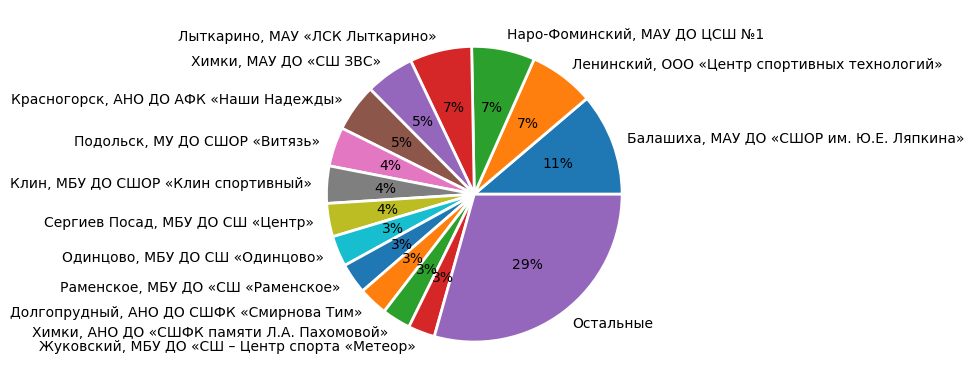

In [7]:
ffkkmo_ra.pie_of_winners(df, 2425, 3, 14, "Доля призеров в сезоне 24-25")
plt.title("", fontsize=16)
plt.xlabel("", fontsize=18)
plt.ylabel("", fontsize=18);

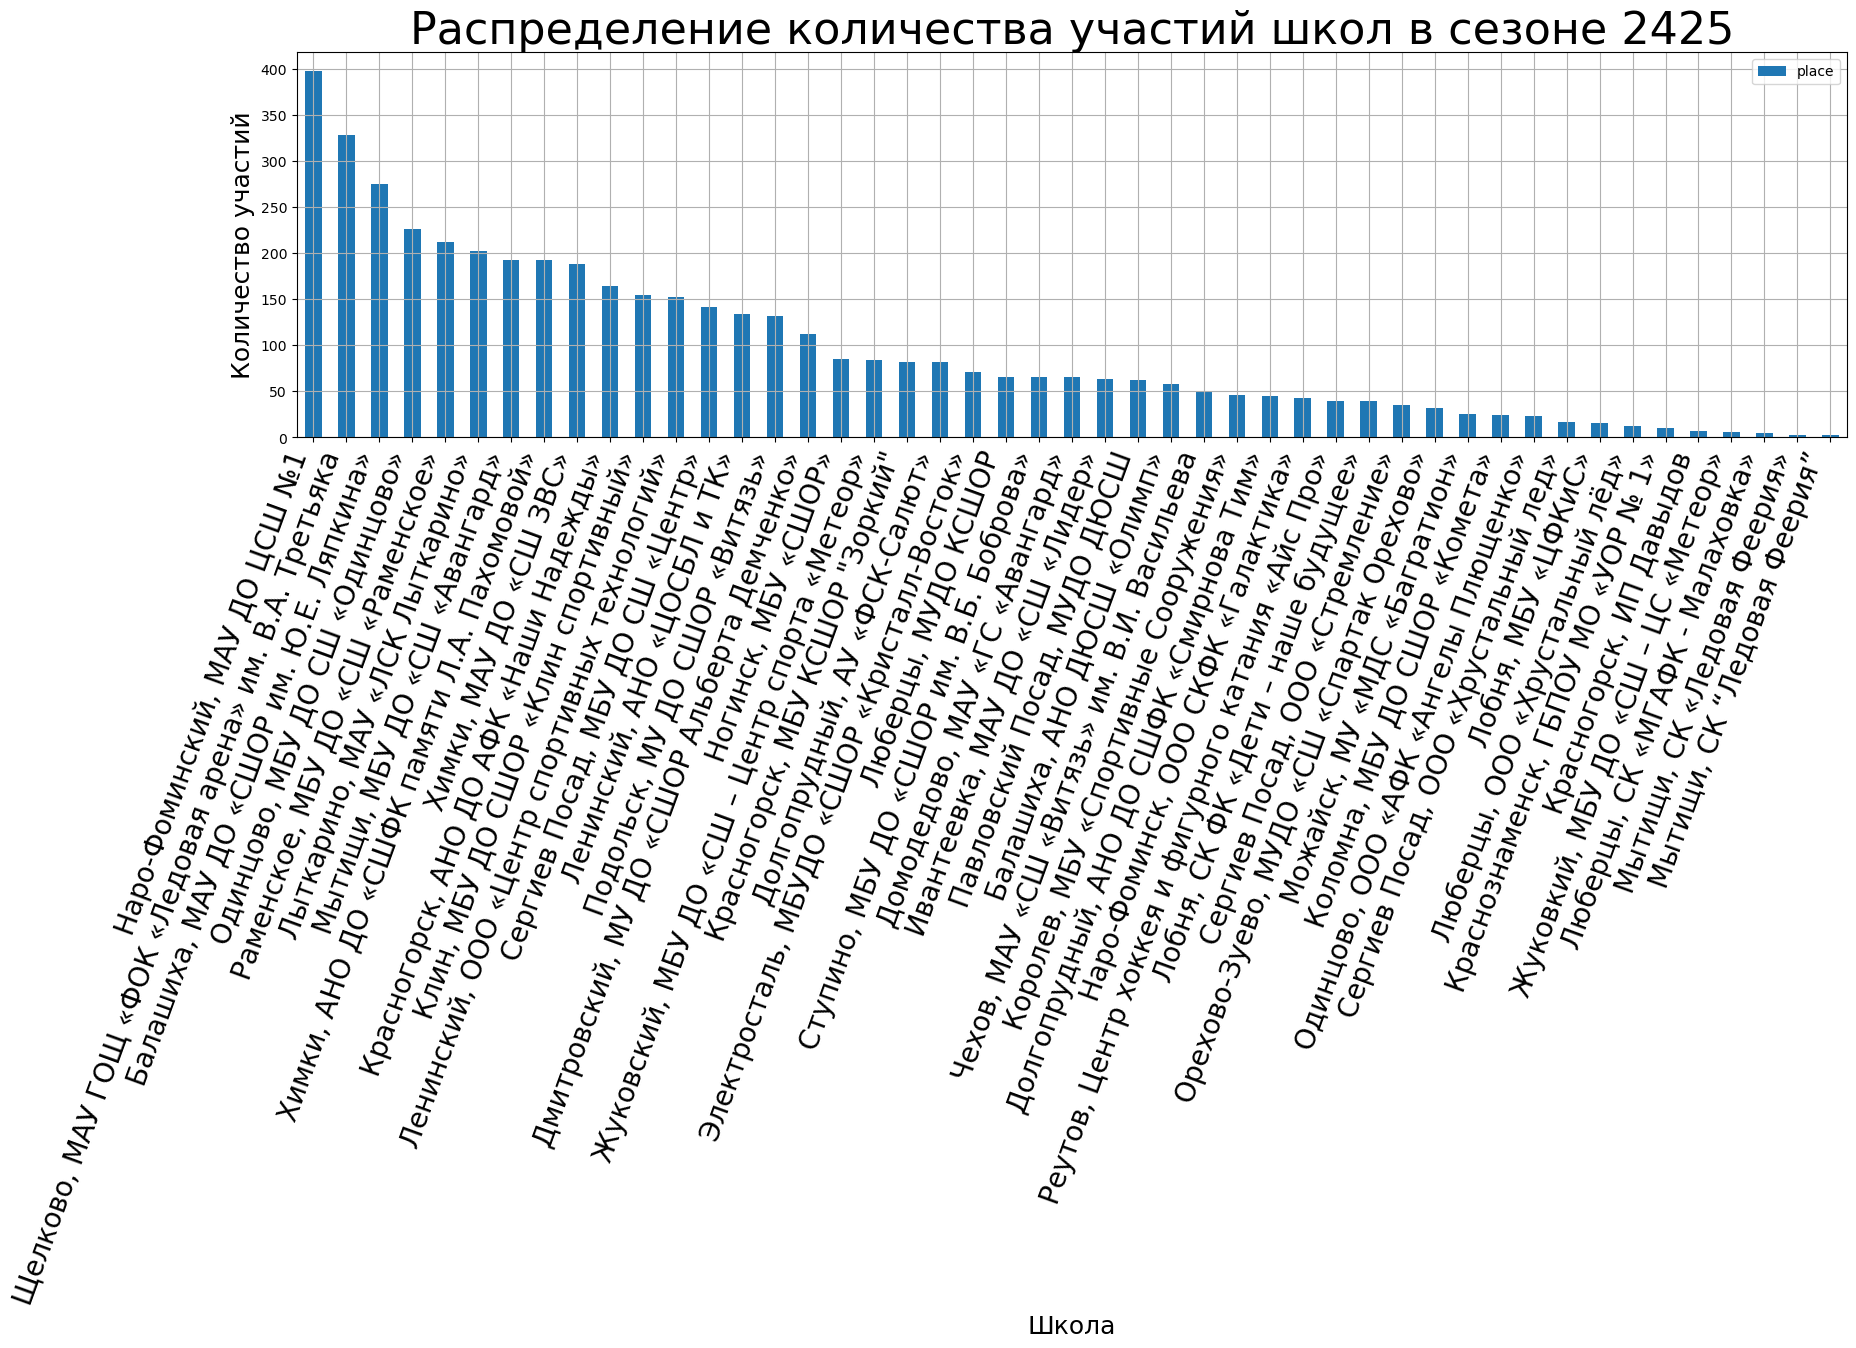

In [8]:
ffkkmo_ra.plot_clubs_in_season(df, season.value, limit_val.value, None)

Empty DataFrame
Columns: [date, firstname, lastname, club, place, online, category, segment, rank, middlename, tss, tes, pcs, year, month, season, label]
Index: []

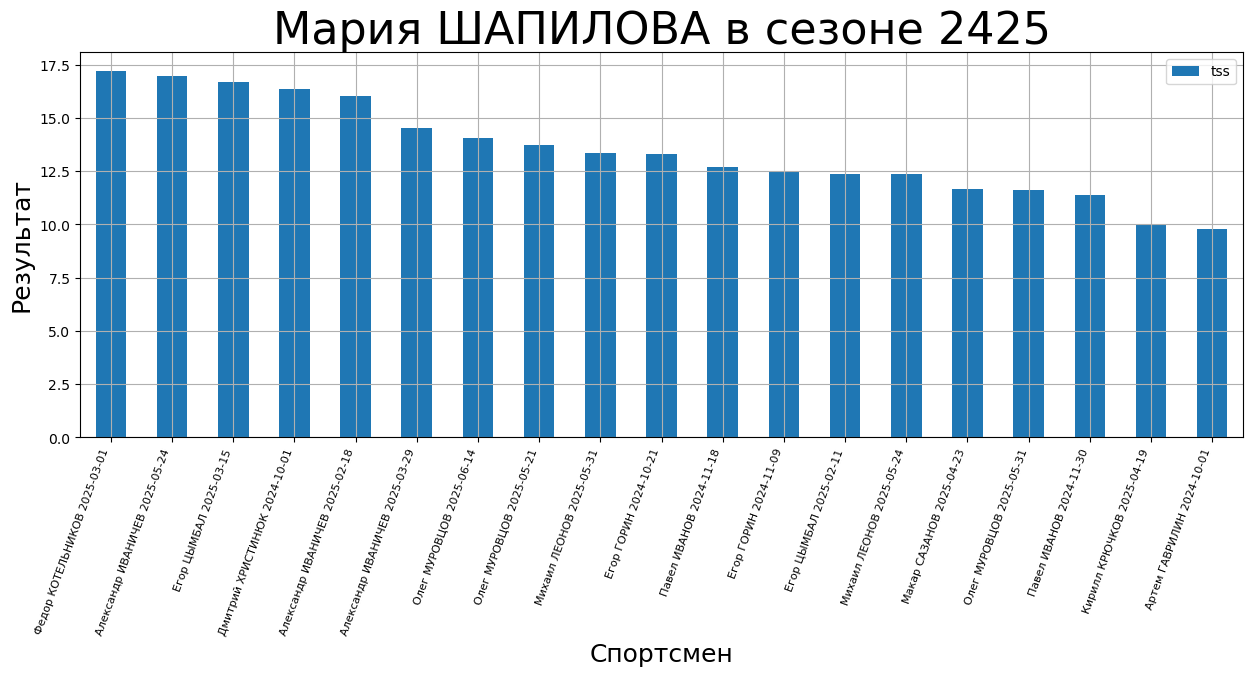

In [9]:
ffkkmo_ra.sportsmen_rating_in_season(df, season.value, category.value, 'Мария', 'ШАПИЛОВА', limit=limit_val.value)

Empty DataFrame
Columns: [date, firstname, lastname, club, place, online, category, segment, rank, middlename, tss, tes, pcs, year, month, season, label]
Index: []

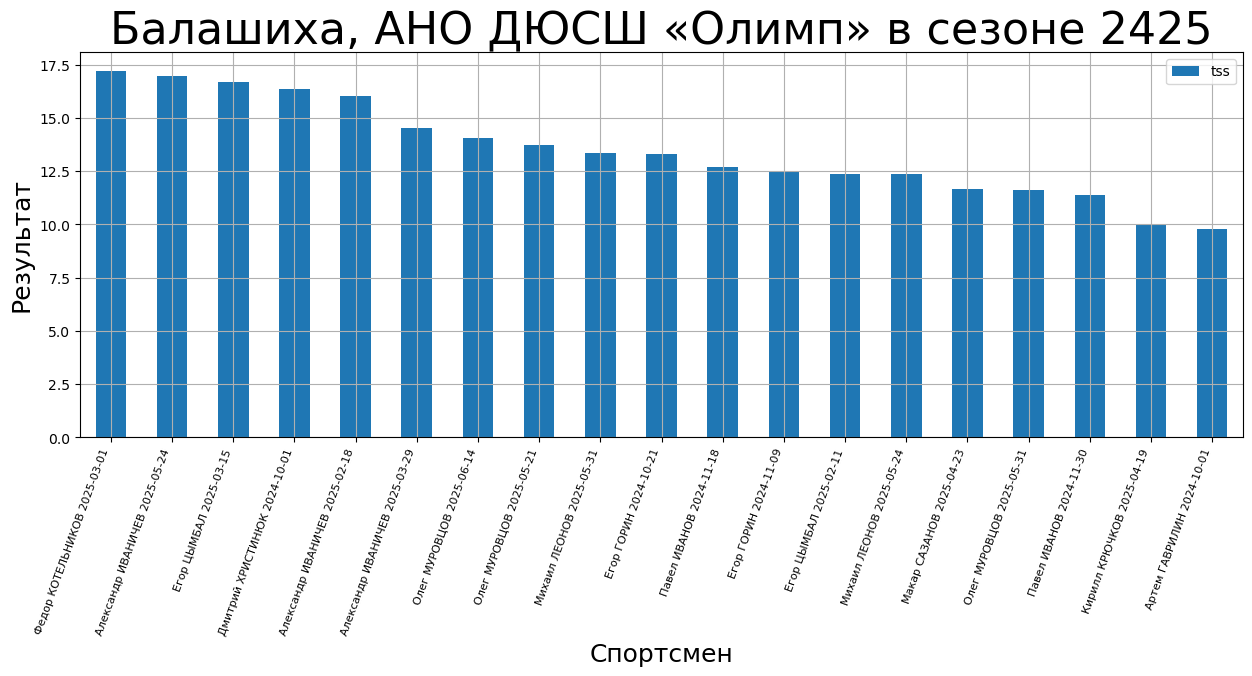

In [10]:
ffkkmo_ra.club_rating_in_season(df, season.value, category.value, club.value, limit=limit_val.value)

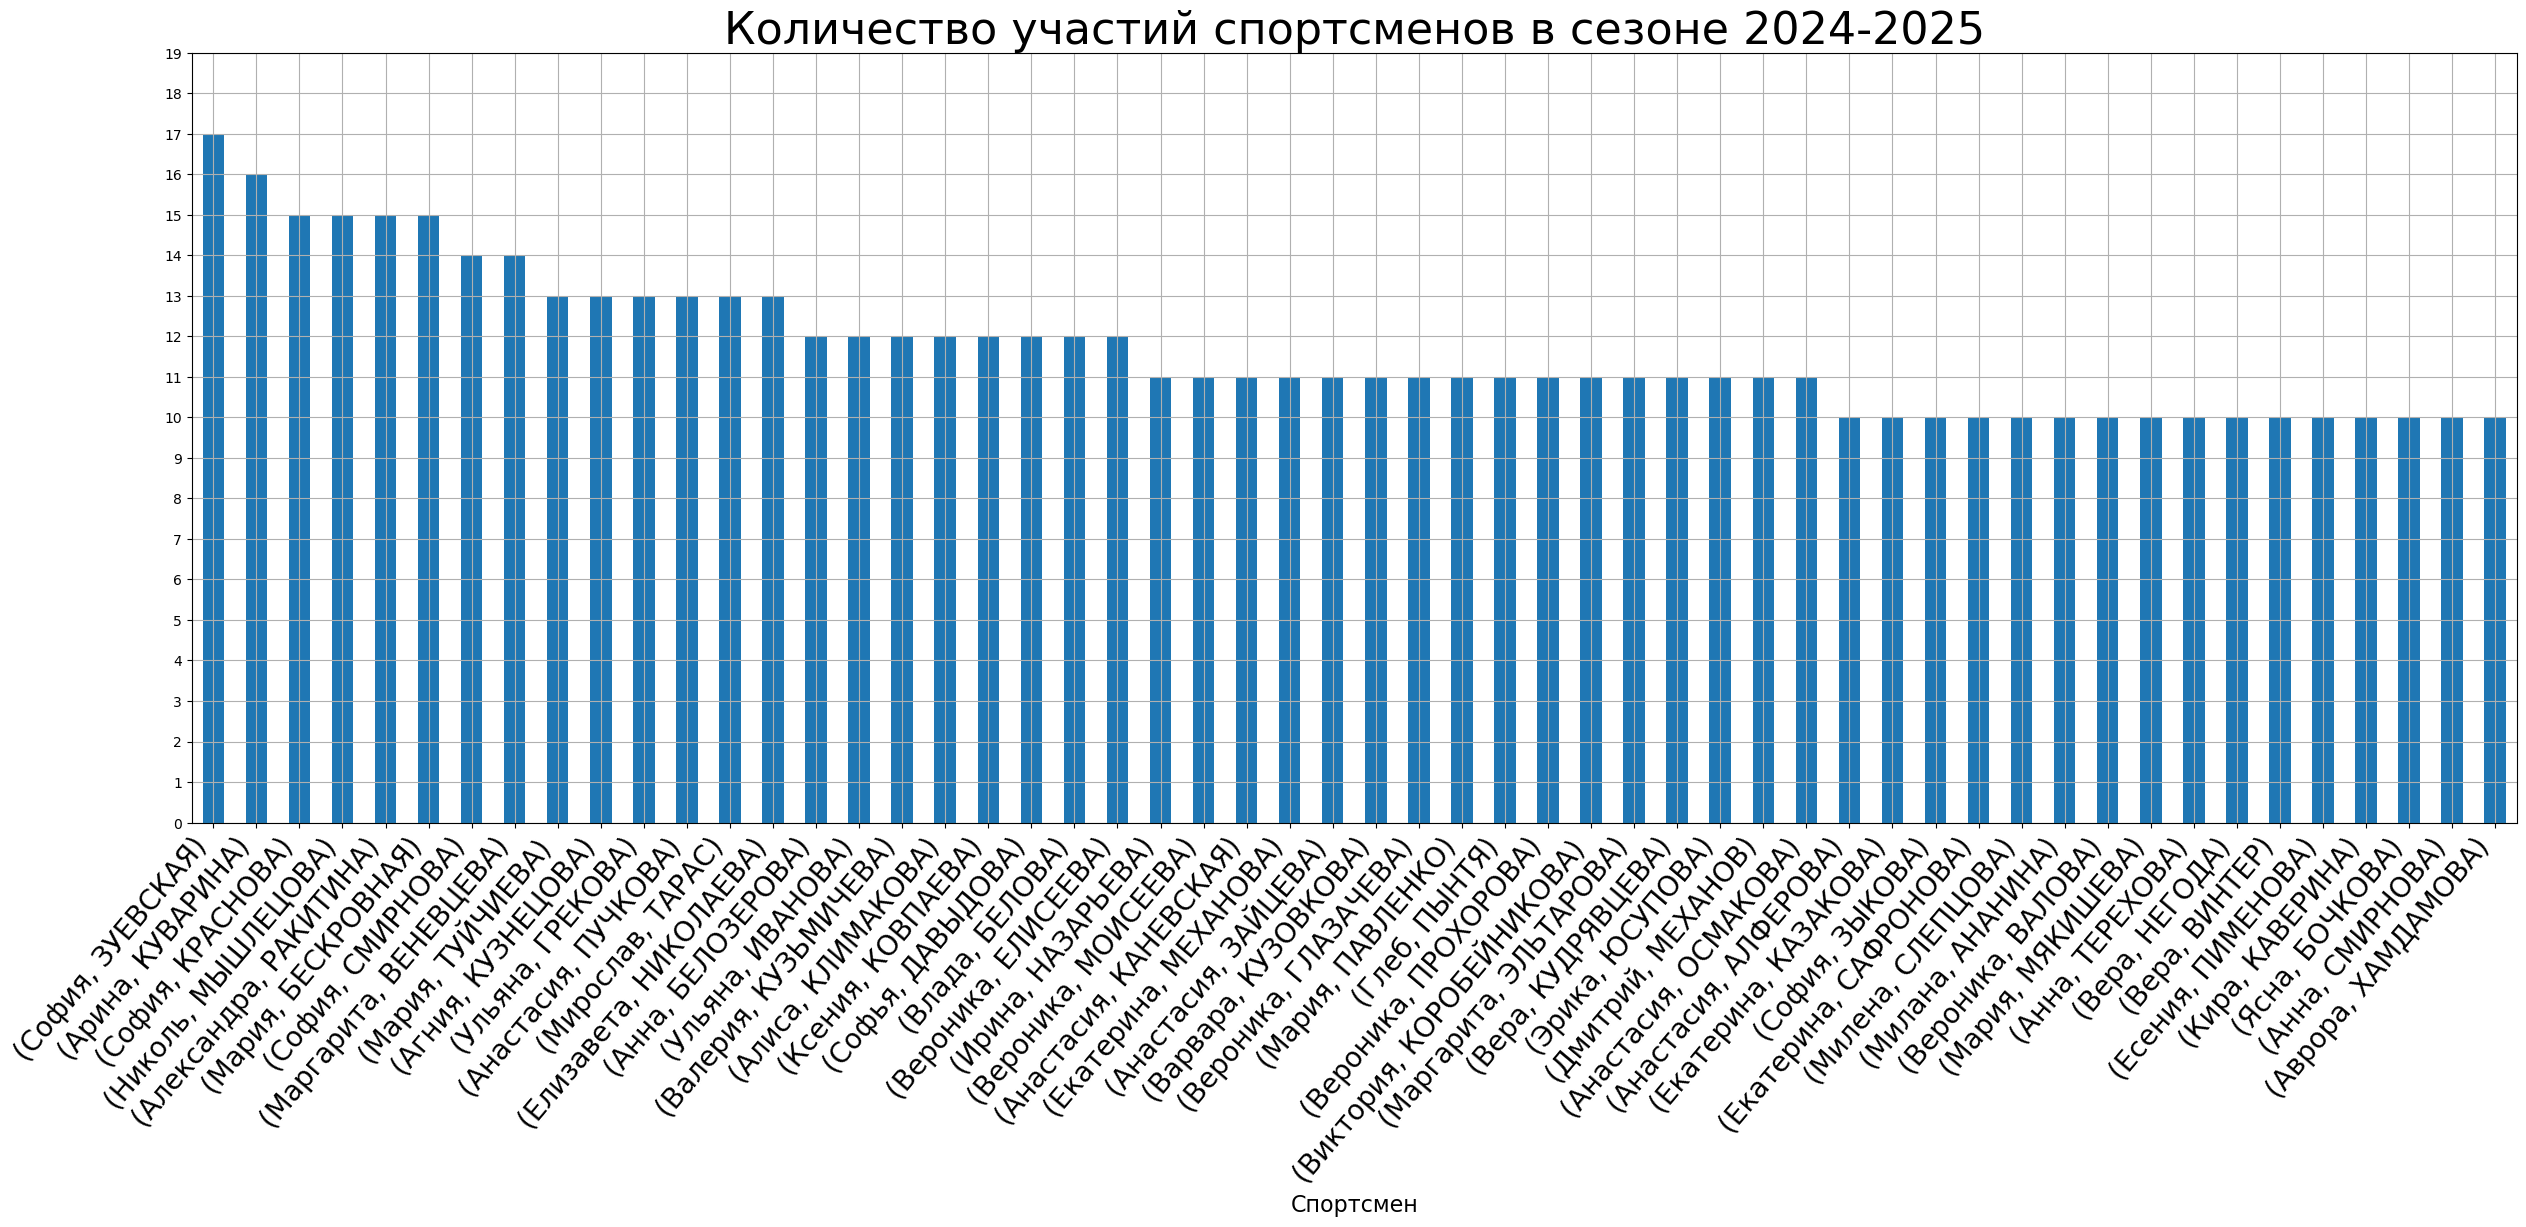

In [11]:
data = df[(df['segment']=='Произвольная программа') & (df['season']==2425)].groupby(['firstname', 'lastname']).count().sort_values(
    by='date', ascending=False).head(54)['date']
ax = data.plot(
    kind='bar', figsize=(30, 10), grid=True
)
major_ticks = np.arange(0, max(data) + 3, 1)
ax.set_yticks(major_ticks)
plt.title("Количество участий спортсменов в сезоне 2024-2025", fontsize=32)
plt.xlabel('Спортсмен', fontsize=16)
plt.ylabel(f'', fontsize=18)
plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');

In [12]:
df[df['category'].isin(categoies)&(df['season']==2425)].sort_values(by="tss").groupby(["category", "segment"]).last()[['club', 'date', 'firstname', 'lastname', 'tss', 'tes', 'pcs']]

club  \
category                        segment                                                                 
1-й спортивный разряд, девочки  Короткая программа           Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»   
                                Произвольная программа   Ленинский, ООО «Центр спортивных технологий»   
1-й спортивный разряд, мальчики Короткая программа                    Сергиев Посад, ООО «Стремление»   
                                Произвольная программа                Сергиев Посад, ООО «Стремление»   
1-й юношеский разряд, девочки   Произвольная программа        Ступино, МБУ ДО «СШОР им. В.Б. Боброва»   
1-й юношеский разряд, мальчики  Произвольная программа                Сергиев Посад, ООО «Стремление»   
2-й спортивный разряд, девочки  Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
2-й спортивный разряд, мальчики Короткая программа                  Раменское, МБУ ДО «СШ «Раменское»   
                                Произвольная программа                 Лыткарино, МАУ «ЛСК Лыткарино»   
2-й юношеский разряд, девочки   Произвольная программа                  Мытищи, МБУ ДО «СШ «Авангард»   
2-й юношеский разряд, мальчики  Произвольная программа       Долгопрудный, АНО ДО СШФК «Смирнова Тим»   
3-й спортивный разряд, девочки  Произвольная программа                  Подольск, МУ ДО СШОР «Витязь»   
3-й спортивный разряд, мальчики Произвольная программа                            Люберцы, МУДО КСШОР   
3-й юношеский разряд, девочки   Произвольная программа         Красногорск, АНО ДО АФК «Наши Надежды»   
3-й юношеский разряд, мальчики  Произвольная программа       Долгопрудный, АНО ДО СШФК «Смирнова Тим»   
КМС, девушки                    Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
КМС, юноши                      Короткая программа               Одинцово, ООО «АФК «Ангелы Плющенко»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
МС, девушки                     Короткая программа               Одинцово, ООО «АФК «Ангелы Плющенко»   
                                Произвольная программа       Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»   
МС, юноши                       Короткая программа               Одинцово, ООО «АФК «Ангелы Плющенко»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
Младшая группа, девочки         Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа   Ленинский, ООО «Центр спортивных технологий»   
Младшая группа, мальчики        Короткая программа                     Одинцово, МБУ ДО СШ «Одинцово»   
                                Произвольная программа              Раменское, МБУ ДО «СШ «Раменское»   
Старшая группа, девочки         Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа   Ленинский, ООО «Центр спортивных технологий»   
Старшая группа, мальчики        Короткая программа                    Сергиев Посад, ООО «Стремление»   
                                Произвольная программа                Сергиев Посад, ООО «Стремление»   
Юный фигурист, девочки          Катание под музыку                             Химки, МАУ ДО «СШ ЗВС»   
                                Произвольная программа  Жуковский, МБУ ДО «СШ – Центр спорта «Метеор»   
Юный фигурист, мальчики         Катание под музыку                     Лыткарино, МАУ «ЛСК Лыткарино»   
                                Произвольная программа              Раменское, МБУ ДО «СШ «Раменское»   

                                                              date  firstname  \
category                 

In [13]:
df[(df['season']==2425)].groupby("category").count()['date']

category
1-й спортивный разряд, девочки      914
1-й спортивный разряд, мальчики      72
1-й юношеский разряд, девочки       455
1-й юношеский разряд, мальчики       27
2-й спортивный разряд, девочки     1323
2-й спортивный разряд, мальчики      50
2-й юношеский разряд, девочки       902
2-й юношеский разряд, мальчики       78
3-й спортивный разряд, девочки      759
3-й спортивный разряд, мальчики      65
3-й юношеский разряд, девочки       628
3-й юношеский разряд, мальчики       19
КМС, девушки                        102
КМС, юноши                           30
МС, девушки                           6
МС, юноши                            12
Младшая группа, девочки              59
Младшая группа, мальчики             10
Старшая группа, девочки              60
Старшая группа, мальчики              8
Юный фигурист, девочки              188
Юный фигурист, мальчики              16
Name: date, dtype: int64

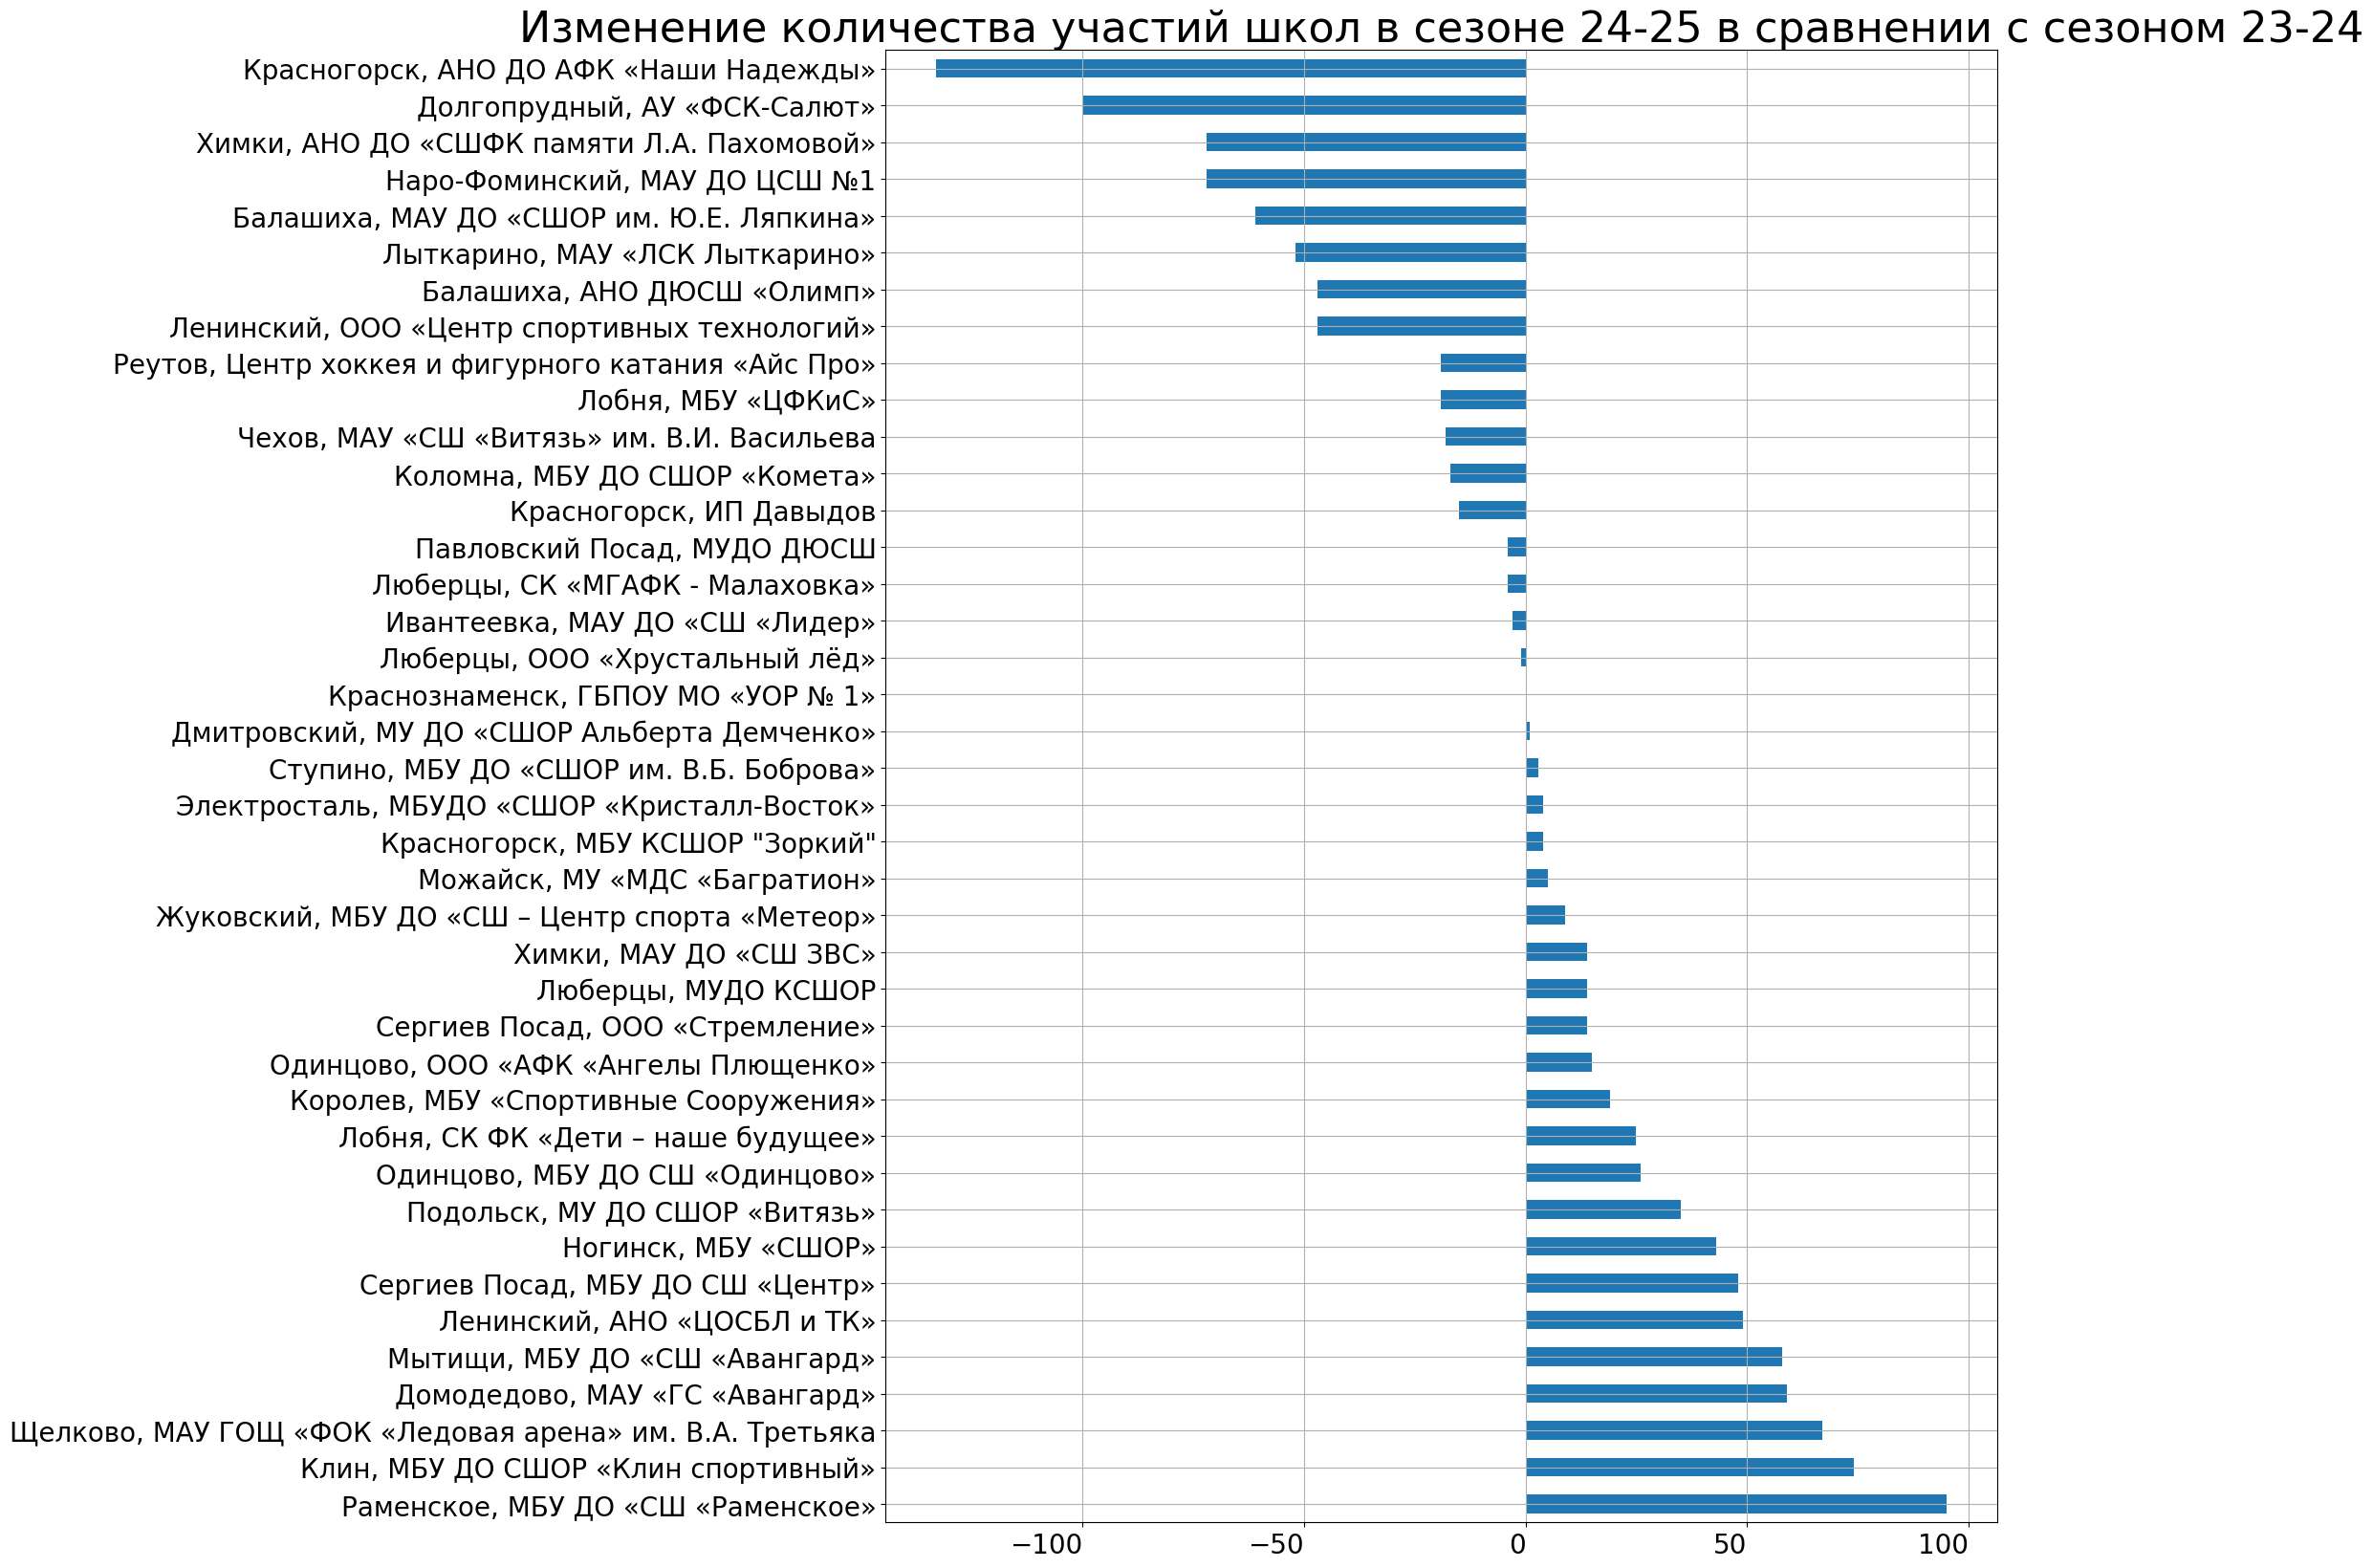

In [14]:
df_groupped = df.groupby(["firstname", "lastname", "date", "club", "season"]).last().reset_index()
pivot_df = pd.pivot_table(df_groupped, values='date', index='club', columns='season', aggfunc='count')
tdf = pivot_df[2425] - pivot_df[2324]
tdf = tdf.dropna()
tdf.sort_values(ascending=False).plot(
    kind='barh', figsize=(15, 20), grid=True
)
plt.title("Изменение количества участий школ в сезоне 24-25 в сравнении с сезоном 23-24", fontsize=32)
plt.ylabel(f'', fontsize=18)
plt.yticks(fontsize=20, rotation=0, horizontalalignment='right');
plt.xticks(fontsize=20, rotation=0, horizontalalignment='right');

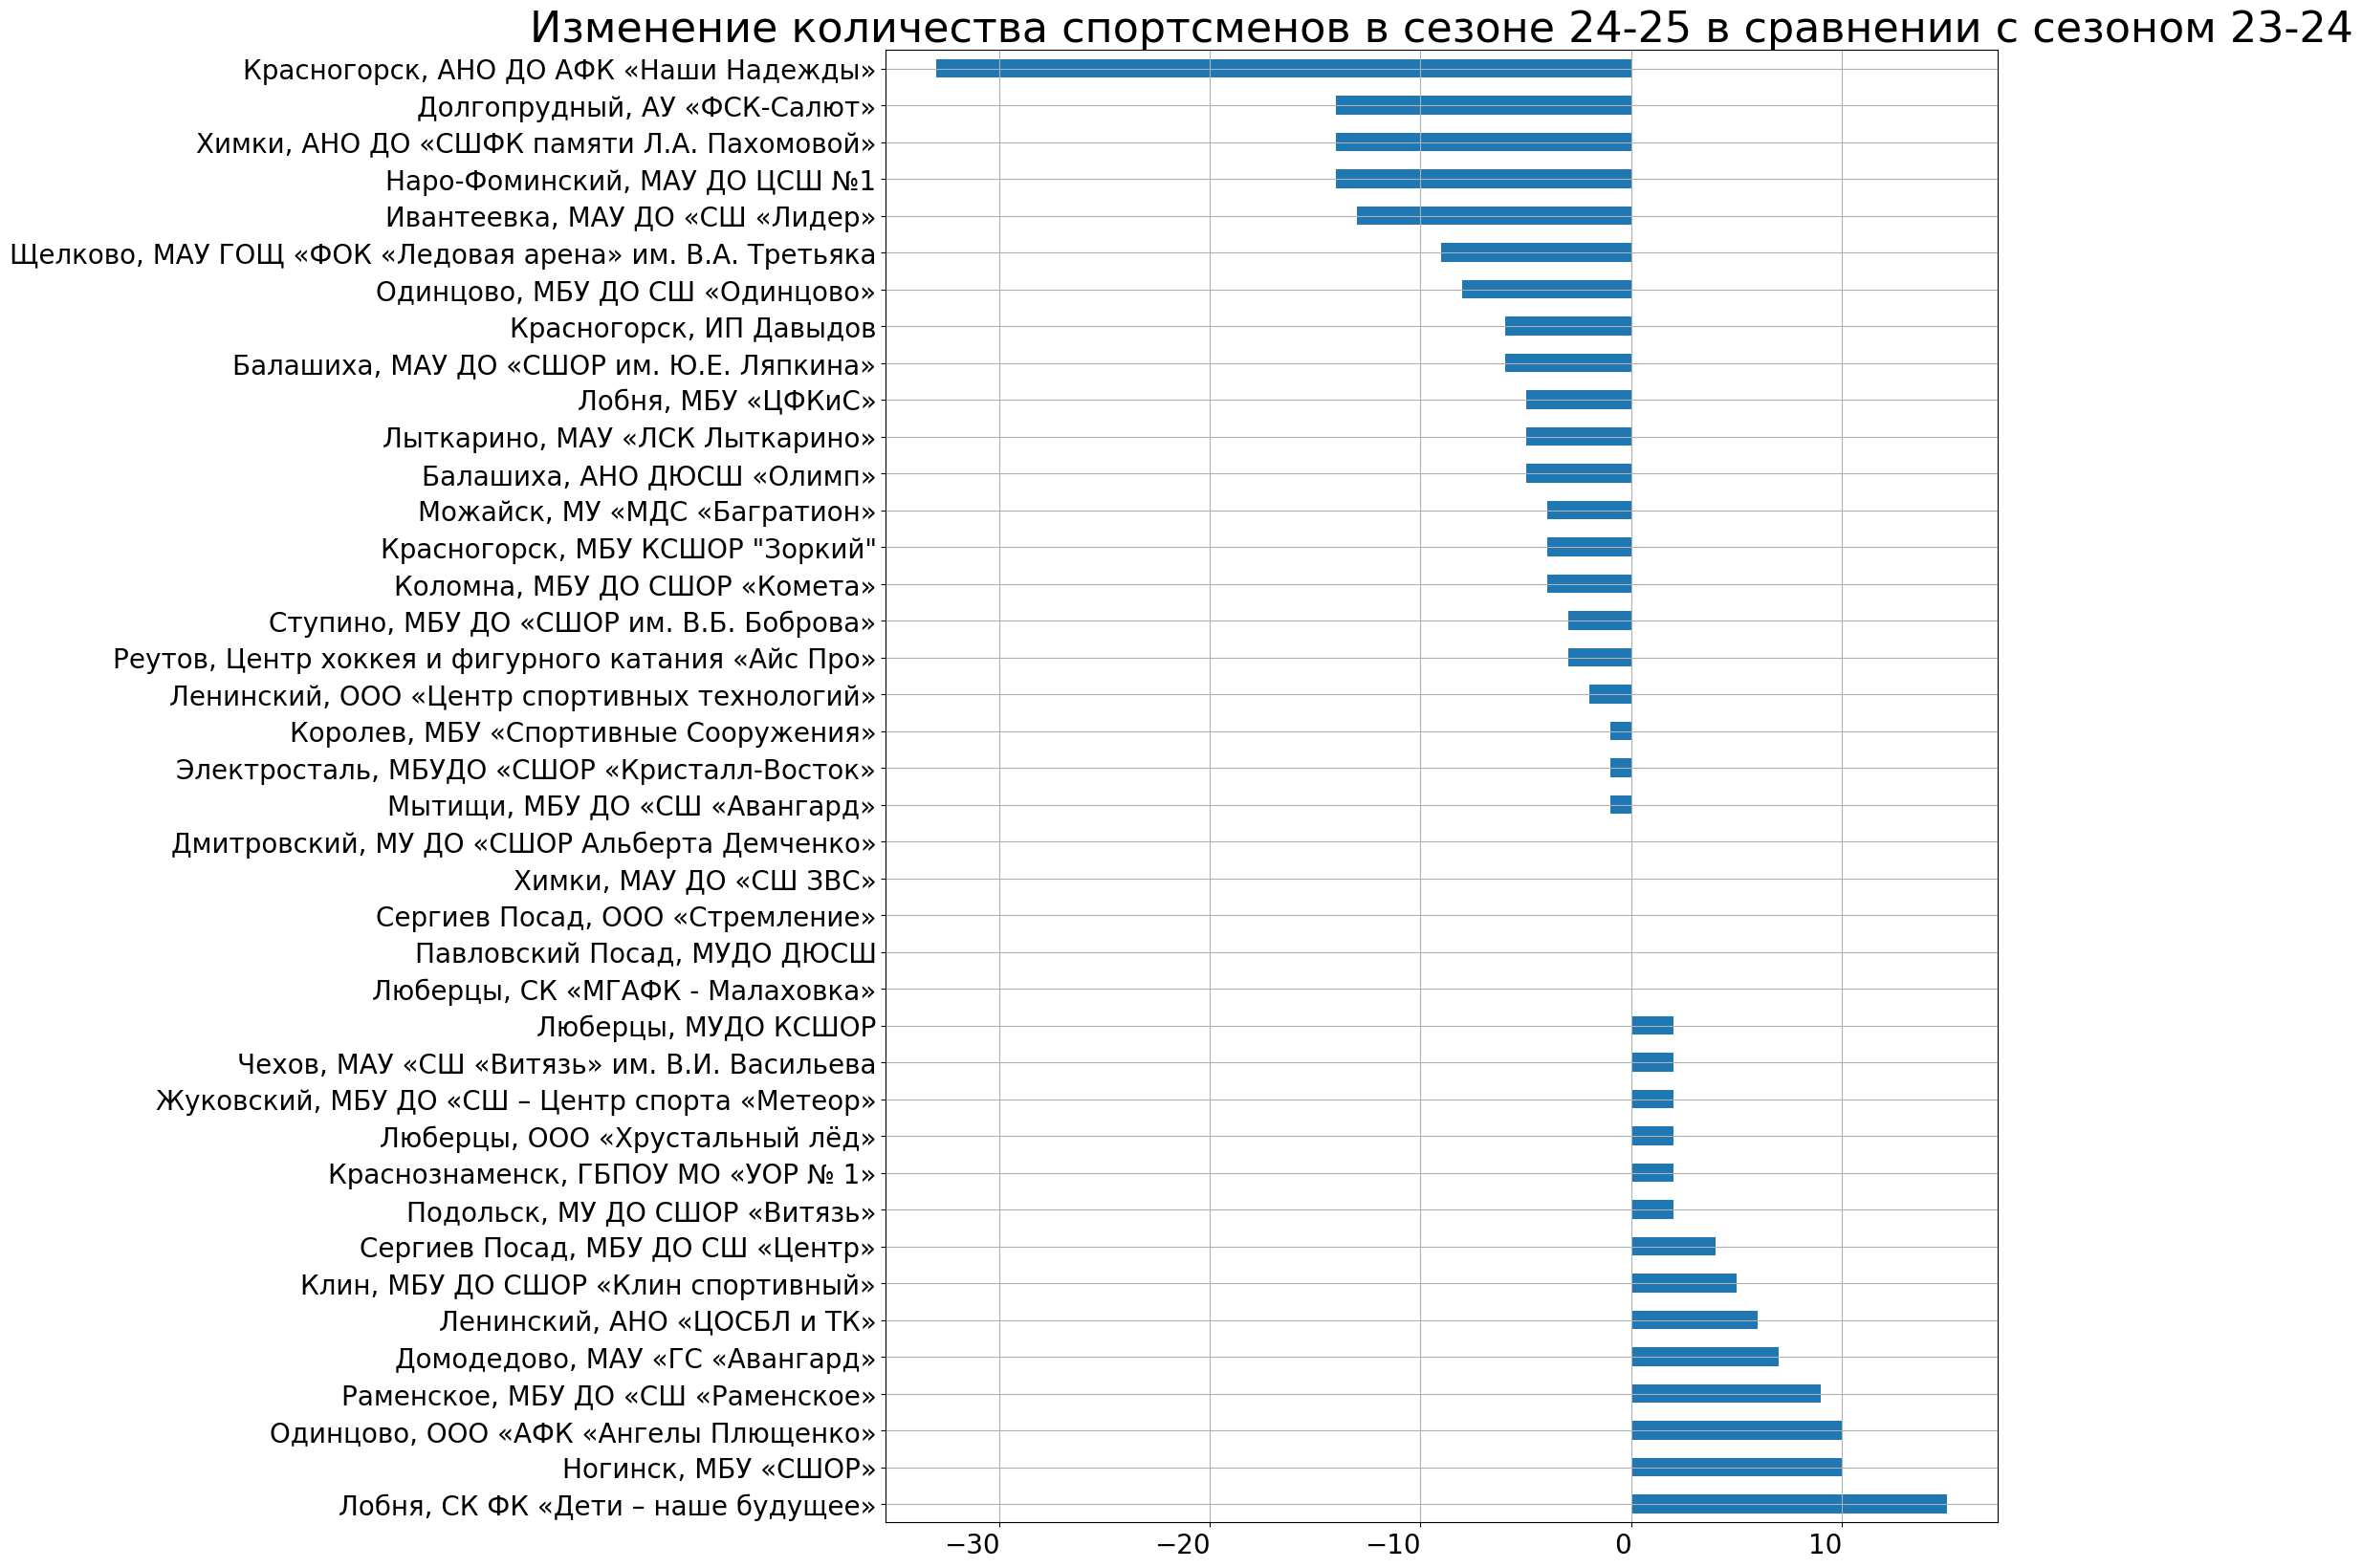

In [15]:
df_groupped = df.groupby(["firstname", "lastname", "club", "season"]).last().reset_index()
pivot_df = pd.pivot_table(df_groupped, values='date', index='club', columns='season', aggfunc='count')
tdf = pivot_df[2425] - pivot_df[2324]
tdf = tdf.dropna()
tdf.sort_values(ascending=False).plot(
    kind='barh', figsize=(15, 20), grid=True
)
plt.title("Изменение количества спортсменов в сезоне 24-25 в сравнении с сезоном 23-24", fontsize=32)
plt.ylabel(f'', fontsize=18)
plt.yticks(fontsize=20, rotation=0, horizontalalignment='right');
plt.xticks(fontsize=20, rotation=0, horizontalalignment='right');

In [16]:
pd.set_option('display.max_rows', 100)
display(pivot_df.sort_values(by=2425, ascending=False))

season                                               2021   2122   2223  \
club                                                                      
Наро-Фоминский, МАУ ДО ЦСШ №1                        39.0   40.0   81.0   
Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»             95.0   90.0   76.0   
Одинцово, МБУ ДО СШ «Одинцово»                      129.0  114.0  114.0   
Лыткарино, МАУ «ЛСК Лыткарино»                       76.0   73.0   63.0   
Раменское, МБУ ДО «СШ «Раменское»                    34.0   37.0   46.0   
Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. ...   66.0   60.0   56.0   
Мытищи, МБУ ДО «СШ «Авангард»                        65.0   62.0   49.0   
Химки, МАУ ДО «СШ ЗВС»                               37.0   38.0   52.0   
Химки, АНО ДО «СШФК памяти Л.А. Пахомовой»           42.0   45.0   54.0   
Красногорск, АНО ДО АФК «Наши Надежды»               22.0   58.0   69.0   
Ленинский, АНО «ЦОСБЛ и ТК»                          43.0   43.0   36.0   
Клин, МБУ ДО СШОР «Клин спортивный»                  29.0   24.0   21.0   
Сергиев Посад, МБУ ДО СШ «Центр»                     39.0   37.0   33.0   
Подольск, МУ ДО СШОР «Витязь»                        43.0   39.0   25.0   
Ленинский, ООО «Центр спортивных технологий»          NaN   33.0   29.0   
Люберцы, МУДО КСШОР                                  33.0   29.0   25.0   
Ступино, МБУ ДО «СШОР им. В.Б. Боброва»              33.0   30.0   29.0   
Долгопрудный, АУ «ФСК-Салют»                         57.0   59.0   46.0   
Жуковский, МБУ ДО «СШ – Центр спорта «Метеор»         5.0    5.0   22.0   
Лобня, СК ФК «Дети – наше будущее»                   18.0   20.0   12.0   
Дмитровский, МУ ДО «СШОР Альберта Демченко»          30.0   36.0   29.0   
Ногинск, МБУ «СШОР»                                   2.0    9.0   13.0   
Балашиха, АНО ДЮСШ «Олимп»                           14.0   27.0   22.0   
Красногорск, МБУ КСШОР "Зоркий"                      64.0   47.0   32.0   
Ивантеевка, МАУ ДО «СШ «Лидер»                       39.0   25.0    8.0   
Чехов, МАУ «СШ «Витязь» им. В.И. Васильева           19.0   21.0   17.0   
Павловский Посад, МУДО ДЮСШ                          26.0   37.0   21.0   
Долгопрудный, АНО ДО СШФК «Смирнова Тим»              NaN    NaN    NaN   
Наро-Фоминск, ООО СКФК «Галактика»                    NaN    NaN    NaN   
Электросталь, МБУДО «СШОР «Кристалл-Восток»          12.0   13.0   21.0   
Орехово-Зуево, МУДО «СШ «Спартак Орехово»             NaN    NaN    NaN   
Одинцово, ООО «АФК «Ангелы Плющенко»                  NaN    NaN    3.0   
Реутов, Центр хоккея и фигурного катания «Айс Про»    8.0   17.0   19.0   
Домодедово, МАУ «ГС «Авангард»                        NaN    NaN    NaN   
Королев, МБУ «Спортивные Сооружения»                 42.0   20.0   22.0   
Сергиев Посад, ООО «Хрустальный лед»                 10.0    8.0   11.0   
Люберцы, ООО «Хрустальный лёд»                        2.0   15.0    5.0   
Сергиев Посад, ООО «Стремление»                       NaN    NaN    NaN   
Краснознаменск, ГБПОУ МО «УОР № 1»                    NaN    NaN    NaN   
Коломна, МБУ ДО СШОР «Комета»                         6.0    6.0   16.0   
Жуковкий, МБУ ДО «СШ – ЦС «Метеор»                    NaN    NaN    NaN   
Можайск, МУ «МДС «Багратион»                          1.0    5.0    NaN   
Лобня, МБУ «ЦФКиС»                                   14.0   16.0    9.0   
Мытищи, СК “Ледовая Феерия”                           NaN    NaN    NaN   
Мытищи, СК «Ледовая Феерия»                           NaN    NaN    NaN   
Красногорск, ИП Давыдов                               NaN   23.0   26.0   
Люберцы, СК «МГАФК - Малаховка»                       NaN    NaN    NaN   
Балашиха, СКФК «Голден Стар»                          9.0    NaN    NaN   
Дмитровский, ИП Карпенко                              NaN    8.0    7.0   
Долгопрудный, СК «Альфа»                             22.0    NaN    NaN   
Домодедово, ИП Спицин                                26.0   21.0   17.0   
Домодедово, ШФК Натальи Б

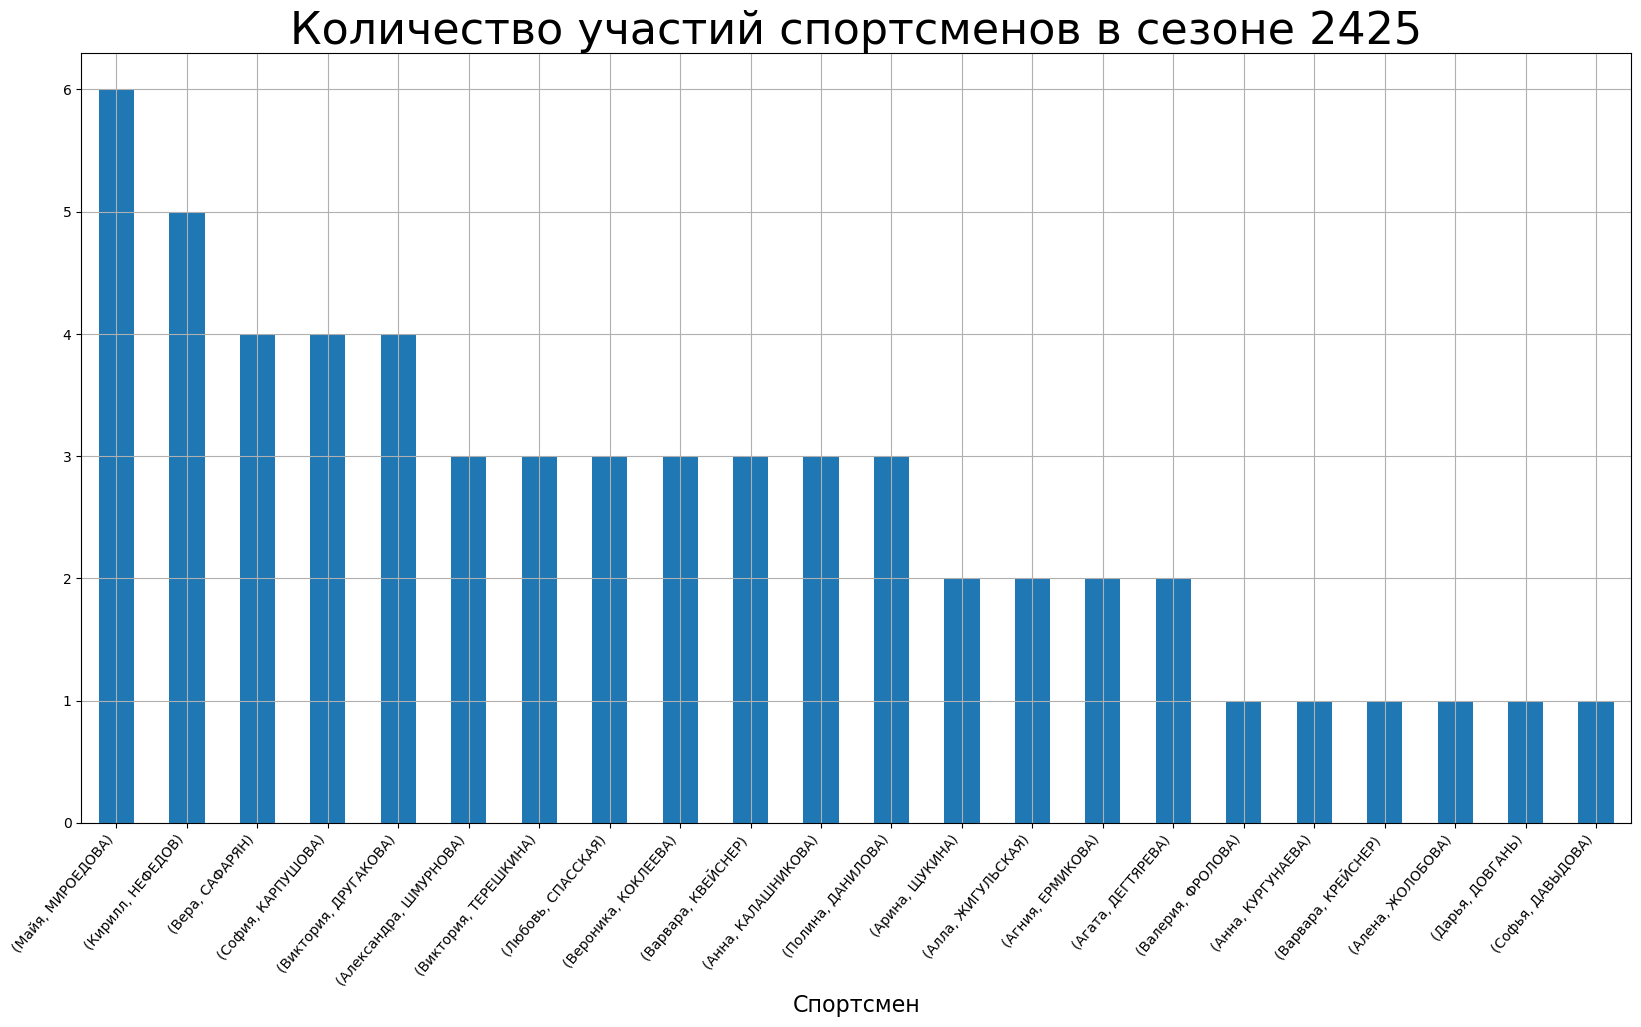

In [17]:
ffkkmo_ra.participants_of_club_in_season(df, club.value, season.value)

In [18]:
def participants_of_club_in_season(df, club, season):
    data = (
        ffkkmo_ra.get_df_of_club_in_season(df, club, season)
        .groupby(["date", "firstname", "lastname"])
        .last()
        .reset_index()
        .groupby(["firstname", "lastname"])
        .count()
        .sort_values(by=["date", "lastname"], ascending=False)["club"]
    )
    ax = data.plot(kind="bar", figsize=(20, 10), grid=True)
    major_ticks = np.arange(0, max(data) + 1, 1)
    ax.set_yticks(major_ticks)
    plt.title(f"Количество участий спортсменов в сезоне {season}", fontsize=32)
    plt.xlabel("Спортсмен", fontsize=16)
    plt.ylabel(f"", fontsize=18)
    plt.xticks(fontsize=10, rotation=50, horizontalalignment="right")

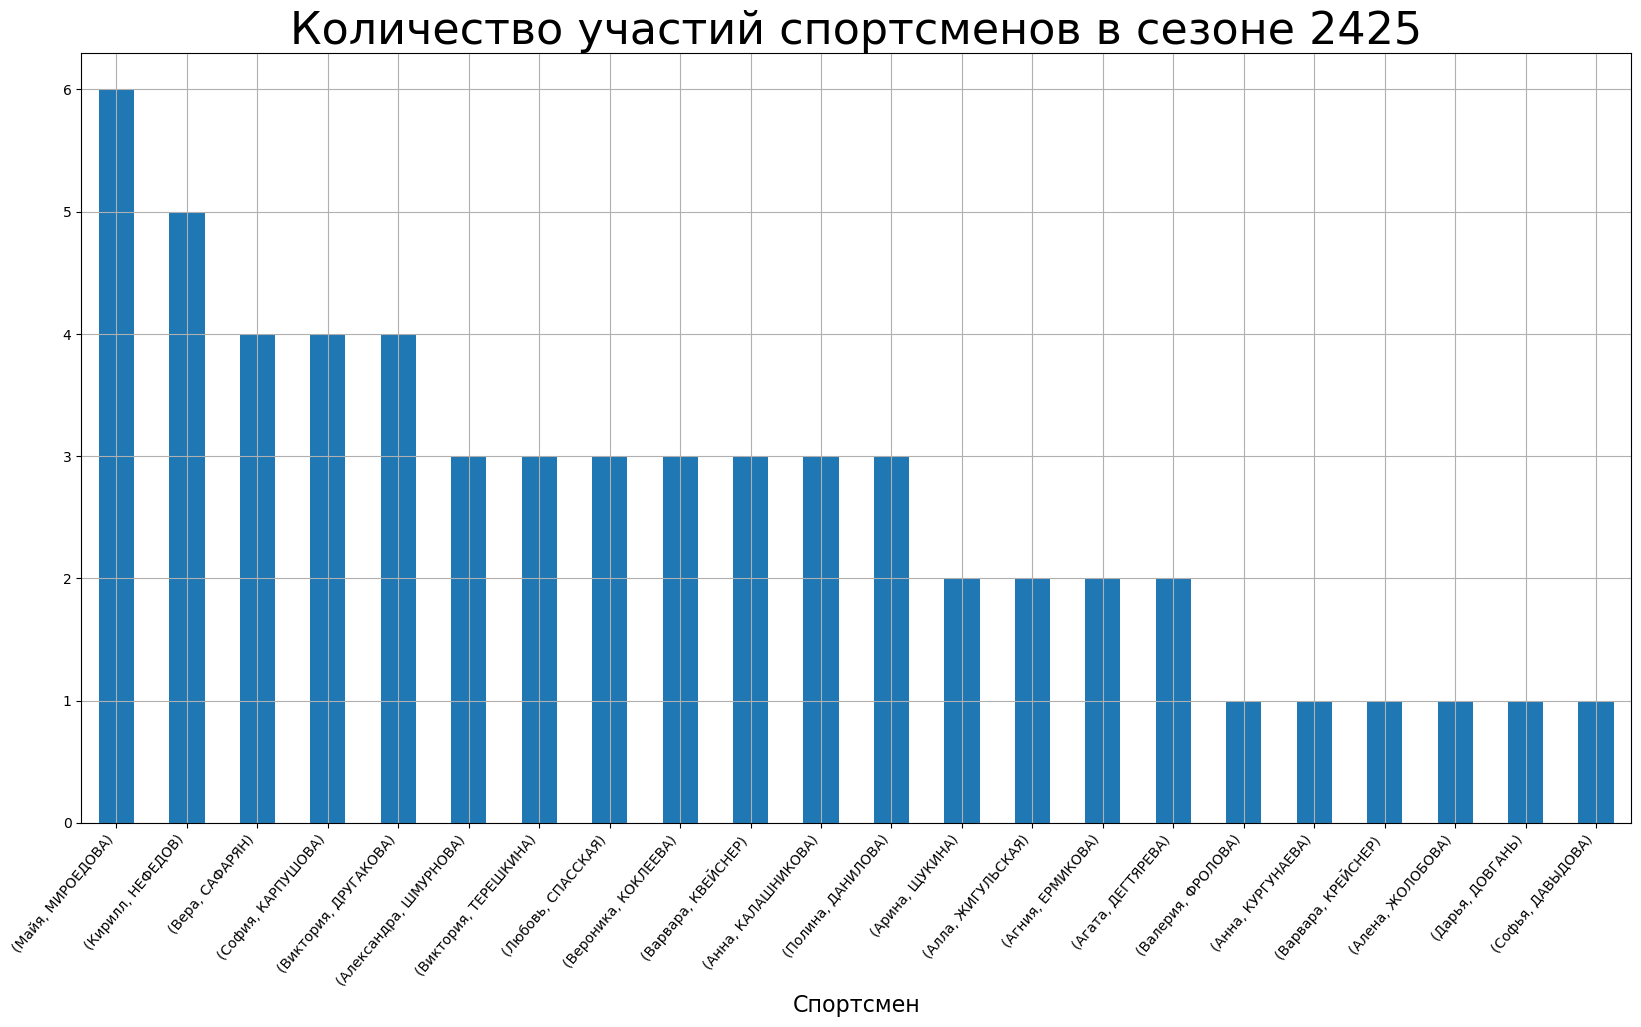

In [19]:
participants_of_club_in_season(df, club.value, season.value)

<Axes: >

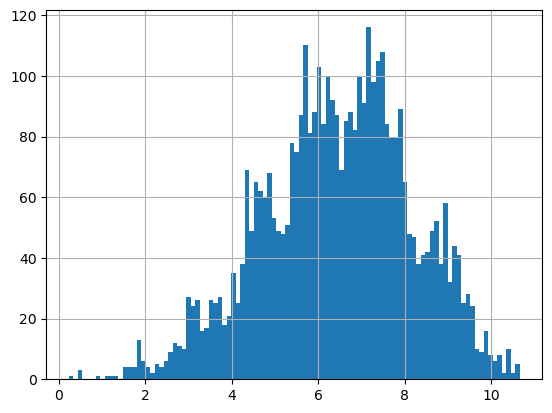

In [20]:
df[(df['category'] == '3-й юношеский разряд, девочки')]['tes'].hist(bins=100)

In [21]:
tes_min = dict(zip([(x[0], x[1]) for x in ffkkmo_ra.sorter_names], [(x[2]) for x in ffkkmo_ra.sorter_names]))

In [22]:
def calc_procentage(x):
    return len(list(filter(lambda y : y > avg(x[1]), x[0]))) / len(x[0]) * 100

In [23]:
for x in tes_min:
    df.loc[(df['category'] == x[0]) & (df['segment'] == x[1]), 'tes_min'] = tes_min[x]
df['tes_done'] = df['tes'] >= df['tes_min']

In [25]:
df_spec = df_judges[df_judges['function'] == 'Технический специалист'].groupby(['date', 'online']).first()
df_spec = df_spec.rename(columns={"name": "ts"})
df_cont = df_judges[df_judges['function'] == 'Технический контролер'].groupby(['date', 'online']).first()
df_cont = df_cont.rename(columns={"name": "tc"})

In [26]:
tes_done_stat = df[df['season'] == 2425].groupby(['club'])['tes_done'].agg(['sum', 'count'])
tes_done_stat['ratio'] = (tes_done_stat['sum']/tes_done_stat['count'])
tes_done_stat = tes_done_stat[tes_done_stat['count'] > 10].sort_values(by='ratio', ascending=False)
tes_done_stat['percentage'] = tes_done_stat['ratio'].apply(lambda x: str(round(x*100, 2)) + '%')

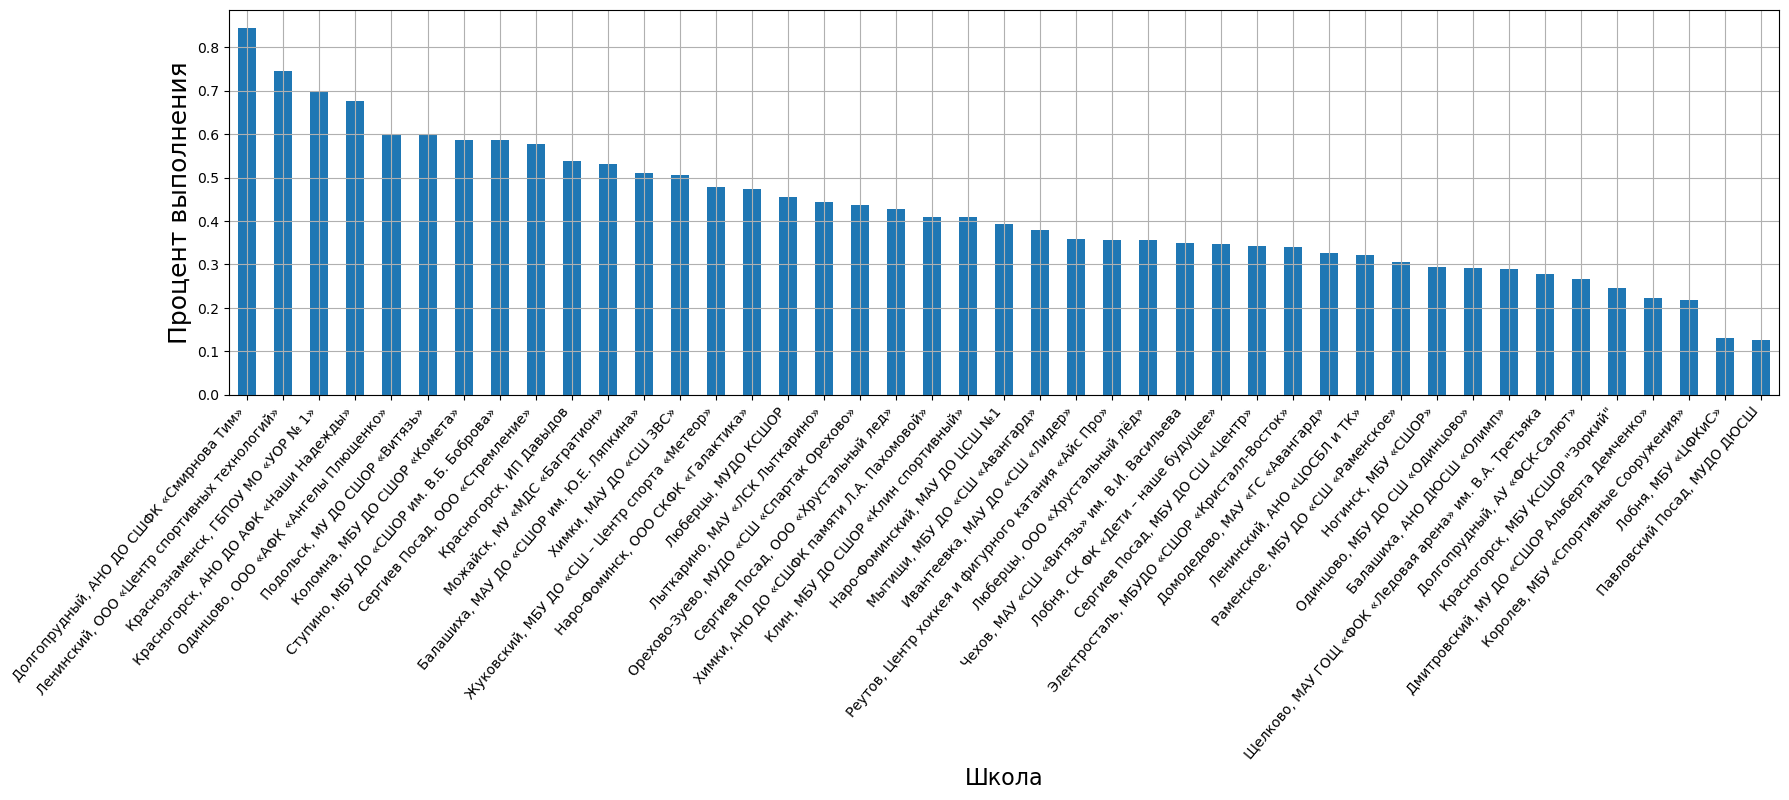

In [27]:
tes_done_stat['ratio'].plot(kind='bar', figsize=(20, 5), grid=True)
plt.xlabel("Школа", fontsize=16)
plt.ylabel(f"Процент выполнения", fontsize=18)
plt.xticks(fontsize=10, rotation=50, horizontalalignment="right");

In [28]:
df_judges = df_judges.groupby(['date', 'name']).first().reset_index()

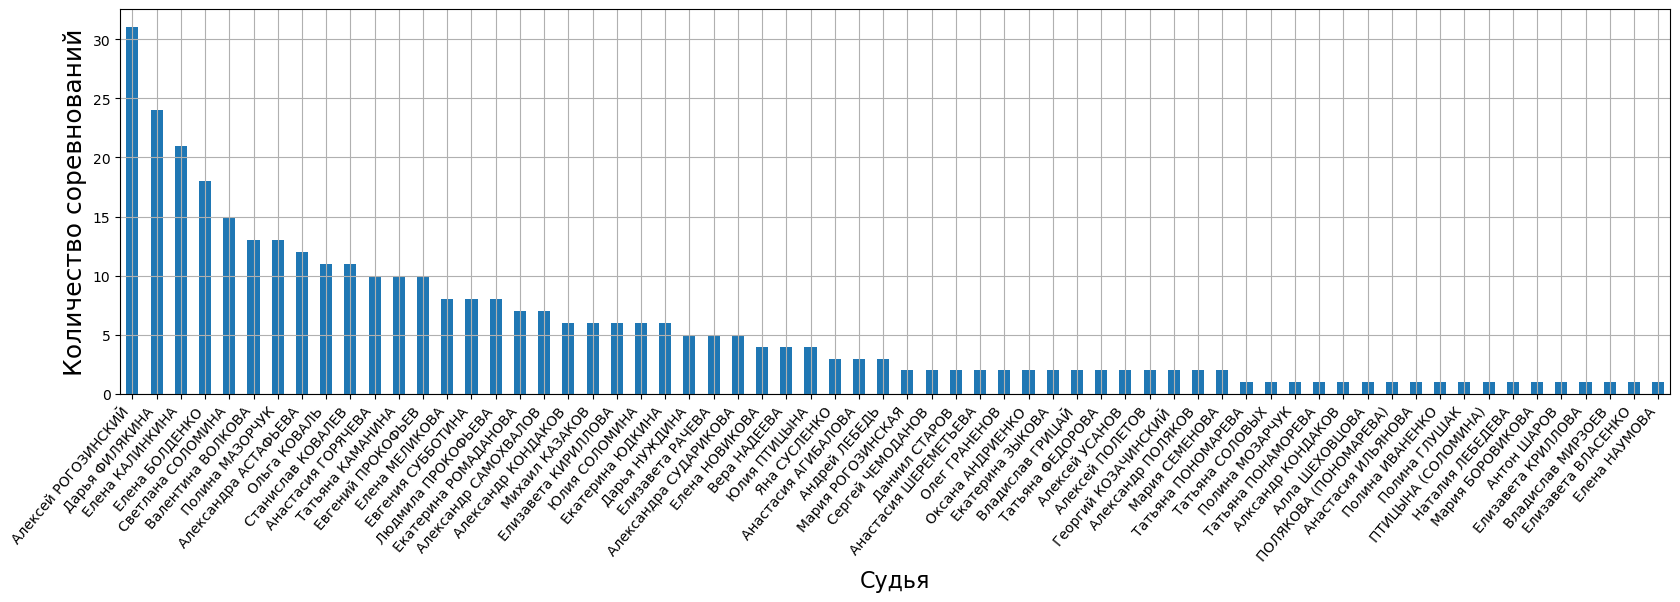

In [29]:
(
    df_judges[df_judges['season'] == 2425]
    .groupby('name')
    .count()
    .sort_values(by='function', ascending=False)['function']
    .plot(kind='bar', grid=True, figsize=(20, 5))
)
plt.xlabel("Судья", fontsize=16)
plt.ylabel(f"Количество соревнований", fontsize=18)
plt.xticks(fontsize=10, rotation=50, horizontalalignment="right");

In [30]:
cat_ord = [
    'Юный фигурист, мальчики',
    'Юный фигурист, девочки',
    '3-й юношеский разряд, мальчики',
    '3-й юношеский разряд, девочки',
    '2-й юношеский разряд, мальчики',
    '2-й юношеский разряд, девочки',
    '1-й юношеский разряд, мальчики',
    '1-й юношеский разряд, девочки',
    '3-й спортивный разряд, мальчики',
    '3-й спортивный разряд, девочки', 
    '2-й спортивный разряд, мальчики',
    '2-й спортивный разряд, девочки',
    '1-й спортивный разряд, мальчики',
    '1-й спортивный разряд, девочки',
    'КМС, юноши',
    'КМС, девушки',
    'МС, юноши',
    'МС, девушки'
]

In [31]:
df = df.drop(df.query("category not in @cat_ord").index).reset_index()

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30517 entries, 0 to 30516
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       30517 non-null  int64  
 1   date        30517 non-null  object 
 2   place       30517 non-null  object 
 3   online      30517 non-null  object 
 4   category    30517 non-null  object 
 5   segment     30517 non-null  object 
 6   rank        30517 non-null  int64  
 7   firstname   30517 non-null  object 
 8   middlename  1296 non-null   object 
 9   lastname    30517 non-null  object 
 10  club        29124 non-null  object 
 11  tss         30517 non-null  float64
 12  tes         30517 non-null  float64
 13  pcs         30517 non-null  float64
 14  year        30517 non-null  int64  
 15  month       30517 non-null  int64  
 16  season      30517 non-null  int64  
 17  tes_min     28812 non-null  float64
 18  tes_done    30517 non-null  bool   
dtypes: bool(1), float64(4), i

In [33]:
df['name'] = df.firstname + df.lastname

In [53]:
df = df.merge(df_spec.merge(df_cont, on=['date', 'online'])[['ts', 'tc']].reset_index(), on=['date', 'online'])

In [61]:
ohe_columns = ['place', 'club', 'segment', 'name', 'ts', 'tc']
ord_columns = ['category', 'season', 'month']
target = ['tss']

train = df.drop(df[df['date'] == '2025-06-14'].index).reset_index(drop=True)
test = df.drop(df[df['date'] != '2025-06-14'].index).reset_index(drop=True)

X_train = train[ohe_columns + ord_columns]
X_test = test[ohe_columns + ord_columns]
y_train = train[target]
y_test = test[target]

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    cat_ord,
                    [2021, 2122, 2223, 2324, 2425],
                    [8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7],
                    # X_train.name.unique(),
                    # X_train.ts.unique(),
                    # X_train.tc.unique()
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
    ], 
    remainder='passthrough'
)
X_train_preprocessed = data_preprocessor.fit_transform(X_train)
X_test_preprocessed = data_preprocessor.transform(X_test)


/home/iuser24/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### DummyRegressor

In [62]:
# Протестируем самую простую модель "Заглушка"
model_dr = DummyRegressor(strategy="mean")
model_dr.fit(X_train_preprocessed, y_train)
model_dr_pred = model_dr.predict(X_test_preprocessed)
dr_mae = mean_absolute_error(model_dr_pred, y_test)
print(f'Значение метрики самой простой модели "Заглушки" MAE = {dr_mae:0.2f}')

Значение метрики самой простой модели "Заглушки" MAE = 10.05


### LinearRegression

In [63]:
lr_grid = GridSearchCV(
    estimator=LinearRegression(),
    cv=10,
    param_grid={},
    scoring='neg_mean_absolute_error', 
    verbose=3
)

lr_grid.fit(X_train_preprocessed, y_train)

# models['LinearRegression'] = (lr_grid.best_score_, lr_grid.best_estimator_)

print(f"MAE score = {abs(lr_grid.best_score_):0.2f}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END ................................., score=-4.755 total time=   0.5s
[CV 2/10] END ................................., score=-4.210 total time=   0.4s
[CV 3/10] END ................................., score=-4.589 total time=   0.5s
[CV 4/10] END ................................., score=-4.286 total time=   0.4s
[CV 5/10] END ................................., score=-4.151 total time=   0.5s
[CV 6/10] END ................................., score=-4.147 total time=   0.4s
[CV 7/10] END ................................., score=-4.329 total time=   0.5s
[CV 8/10] END ................................., score=-3.993 total time=   0.4s
[CV 9/10] END ................................., score=-5.256 total time=   0.4s
[CV 10/10] END ................................, score=-4.307 total time=   0.4s
MAE score = 4.40


### CatBoostRegressor

In [64]:
cbr_params = {
    'iterations': [1000, 2000],
    'learning_rate': [0.01],
    'depth': [6, 8]
}
cbr_grid = GridSearchCV(
    estimator=CatBoostRegressor(
        random_state=42,
        logging_level='Silent',
        loss_function='MAE'
    ),
    param_grid=cbr_params,
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=3
)

cbr_grid.fit(X_train_preprocessed, y_train)

print(f"MAE score = {abs(cbr_grid.best_score_):0.2f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END depth=6, iterations=1000, learning_rate=0.01;, score=-3.359 total time=   9.5s
[CV 2/5] END depth=6, iterations=1000, learning_rate=0.01;, score=-3.983 total time=   9.9s
[CV 3/5] END depth=6, iterations=1000, learning_rate=0.01;, score=-4.157 total time=   9.5s
[CV 4/5] END depth=6, iterations=1000, learning_rate=0.01;, score=-3.922 total time=   9.4s
[CV 5/5] END depth=6, iterations=1000, learning_rate=0.01;, score=-3.759 total time=   9.3s
[CV 1/5] END depth=6, iterations=2000, learning_rate=0.01;, score=-3.337 total time=  19.6s
[CV 2/5] END depth=6, iterations=2000, learning_rate=0.01;, score=-3.855 total time=  19.5s
[CV 3/5] END depth=6, iterations=2000, learning_rate=0.01;, score=-3.994 total time=  20.2s
[CV 4/5] END depth=6, iterations=2000, learning_rate=0.01;, score=-3.775 total time=  22.2s
[CV 5/5] END depth=6, iterations=2000, learning_rate=0.01;, score=-3.653 total time=  19.3s
[CV 1/5] END depth=8

In [70]:
y_train['tss'].shape

(29921,)

### RandomForestRegressor

In [84]:
fr_params = {
    'n_estimators': [10],
    'max_depth': [8, 16],
    # 'min_samples_split': [8, 16]
}
fr_grid = GridSearchCV(
    estimator=RandomForestRegressor(
        criterion='absolute_error',
        random_state=42
    ),
    param_grid=fr_params,
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=3
)

fr_grid.fit(X_train_preprocessed[:3000], y_train['tss'][:3000])

print(f"MAE score = {abs(fr_grid.best_score_):0.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .....max_depth=8, n_estimators=10;, score=-3.089 total time=  10.4s
[CV 2/5] END .....max_depth=8, n_estimators=10;, score=-3.036 total time=  10.3s
[CV 3/5] END .....max_depth=8, n_estimators=10;, score=-2.685 total time=  10.9s
[CV 4/5] END .....max_depth=8, n_estimators=10;, score=-3.250 total time=  10.3s
[CV 5/5] END .....max_depth=8, n_estimators=10;, score=-3.575 total time=  10.1s
[CV 1/5] END ....max_depth=16, n_estimators=10;, score=-3.005 total time=  12.2s
[CV 2/5] END ....max_depth=16, n_estimators=10;, score=-2.857 total time=  12.1s
[CV 3/5] END ....max_depth=16, n_estimators=10;, score=-2.644 total time=  12.7s
[CV 4/5] END ....max_depth=16, n_estimators=10;, score=-3.060 total time=  12.2s
[CV 5/5] END ....max_depth=16, n_estimators=10;, score=-3.459 total time=  11.9s
MAE score = 3.00


In [ ]:
X_train_scaled_tensor = torch.tensor(X_train_preprocessed.todense(), dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float)
X_valid_scaled_tensor = torch.tensor(X_test_preprocessed.todense(), dtype=torch.float)
y_valid_tensor = torch.tensor(y_test.values, dtype=torch.float)

In [ ]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3) 
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.fa1 = nn.ELU()
        self.fa2 = nn.LeakyReLU()
        self.fa3 = nn.ELU()
        self.fa4 = nn.ReLU()
        self.dp1 = nn.Dropout()
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.dp2 = nn.Dropout()
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.fa1(out)
        out = self.dp1(out)
        out = self.fc2(out)
        # out = self.bn2(out)
        out = self.fa2(out)
        # out = self.dp2(out)
        out = self.fc3(out)
        out = self.fa3(out)
        out = self.fc4(out)
        out = self.fa4(out)
        
        return out

In [ ]:
n_in_neurons = X_train_scaled_tensor.shape[1]
n_hidden_neurons_1 = X_train_scaled_tensor.shape[1]*4
n_hidden_neurons_2 = X_train_scaled_tensor.shape[1]*2
n_hidden_neurons_3 = X_train_scaled_tensor.shape[1]//2
n_out_neurons = 1
lr=0.001
num_epochs = 10000
per_epochs = 100

In [ ]:
def MAELoss(yhat,y):
    return torch.abs(yhat - y).mean()

In [ ]:
X_train_scaled_tensor.shape

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

loss = MAELoss
mae_min = float('inf')
best_params = None

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train_scaled_tensor).flatten()
    loss_value = loss(preds, y_train_tensor)
    loss_value.backward()
    optimizer.step()

    if epoch % per_epochs == 0 or epoch == num_epochs - 1:
        net.eval()
        valid_preds = net(X_valid_scaled_tensor).flatten()
        mae = loss(valid_preds, y_valid_tensor)
        if mae_min > mae:
            mae_min = mae
            best_params = copy.deepcopy(net.state_dict())
        print(f"Epoch {epoch}/{num_epochs}, MAE = {mae}, best MAE = {mae_min}")

In [ ]:
model = cbr_grid.best_estimator_

In [ ]:
y_pred = model.predict(X_test_preprocessed)

In [ ]:
pd.DataFrame(y_pred)

In [ ]:
result = pd.concat([test, pd.DataFrame(y_pred)], axis=1)

In [ ]:
result.groupby(['category', 'segment', 'name']).first().sort_values(by=0, ascending=False)

In [ ]:
df[(df['firstname'] == 'Анастасия')&(df['lastname'] == 'ЯРОЩУК')]

In [ ]:
data = {
    'season' : 2425, 
    'month' : 6,
    'place': ['г. Химки, ул. Мичурина с.24 к.1, Ледовая арена'], 
    'category': ['3-й спортивный разряд, девочки'],
    'segment': ['Произвольная программа'],
    'name': ['Диана ПРОКОФЬЕВА'],
    'club': ['Люберцы, МУДО КСШОР'],
}
diana = pd.DataFrame.from_dict(data)
model.predict(data_preprocessor.transform(diana))